In [1]:
!pip install einops torch maze-dataset --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random
from torch.nn import functional as F

In [3]:
os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /


## Loading the Dataset

In [ ]:
# from maze.maze_generator import generate_dataset
# n_mazes = 1000
# directory = "./data/"

# generate_dataset(n_mazes, directory) ,

# print("Maze dataset generation complete!")

Generating Mazes:   0%|          | 0/5 [00:00<?, ?maze/s]/usr/local/lib/python3.11/dist-packages/maze_dataset/dataset/dataset.py:95: UserWarning: in GPTDatasetConfig self.name='train', self.seed=1 is trying to override muutils.mlutils.GLOBAL_SEED=42 which has already been changed elsewhere from muutils.mlutils.DEFAULT_SEED=42
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/maze_dataset/generation/generators.py:215: UserWarning: gen_prim does not correctly implement prim's algorithm, see issue: https://github.com/understanding-search/maze-dataset/issues/12
  warnings.warn(
Generating Mazes: 1000maze [00:06, 150.16maze/s]

Maze dataset generation complete!


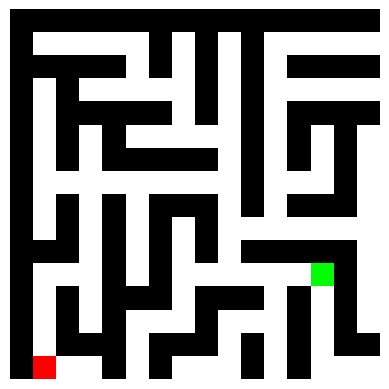

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

def preprocess_image(image, target_size=32):
    image = np.array(image)

    scale_factor = target_size // image.shape[0]
    image = np.kron(image, np.ones((scale_factor, scale_factor, 1)))

    image = image.astype(np.float32) / 127.5 - 1
    image = torch.tensor(image).permute(2, 0, 1)
    return image

def load_dataset_from_npy(directory="./data", target_size=32):
    images = []
    path_lengths = []

    files = sorted([f for f in os.listdir(directory) if f.endswith(".npy")])

    for file in files:
        img = np.load(os.path.join(directory, file))

        mask = np.all(img == [0, 0, 255], axis=-1)
        img[mask] = [255, 255, 255]
        img = img[:-1, :-1]

        image = preprocess_image(img, target_size)

        base_name = os.path.splitext(file)[0]
        len_filename = base_name + "_len.txt"
        len_path = os.path.join(directory, len_filename)

        with open(len_path, "r") as f:
            maze_length = int(f.read().strip())

        images.append(image)
        path_lengths.append(maze_length)

    return images, path_lengths

images, path_lengths = load_dataset_from_npy("./data", target_size=32)

plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths):
        self.images = images
        self.path_lengths = path_lengths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx]

# Diffusion

In [8]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /


### VAE Training

In [9]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [10]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 150
LATENT_CHANNELS = 4

In [11]:
print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths)
test_dataset = MazeTensorDataset(test_images, test_path_lengths)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
Number of unique training paths: 22
Unique test path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21}
Number of unique test paths: 19


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import AutoencoderKL
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Stable Diffusion's pre-trained VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)

# Optimizer (Adam for VAE training)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# Loss function (pixel-level reconstruction loss)
criterion = nn.MSELoss()

train_losses = []
# ---- Training Loop ---- #
def train_vae(dataloader, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)  # Input maze images (shape: B x 3 x 256 x 256)

            # Forward pass
            latent_dist = vae.encode(images).latent_dist
            latent_sample = latent_dist.sample()
            reconstructed_images = vae.decode(latent_sample).sample

            # Loss computation
            loss = criterion(reconstructed_images, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

# ---- Example Usage ---- #
# Assuming you have a DataLoader ready: `maze_dataloader`
train_vae(dataloader, epochs=50)


Using device: cuda
Epoch [1/50], Loss: 0.148116
Epoch [2/50], Loss: 0.055280
Epoch [3/50], Loss: 0.038900
Epoch [4/50], Loss: 0.034031
Epoch [5/50], Loss: 0.030915
Epoch [6/50], Loss: 0.028954
Epoch [7/50], Loss: 0.027667
Epoch [8/50], Loss: 0.027300
Epoch [9/50], Loss: 0.026647
Epoch [10/50], Loss: 0.025662
Epoch [11/50], Loss: 0.026000
Epoch [12/50], Loss: 0.023949
Epoch [13/50], Loss: 0.023787
Epoch [14/50], Loss: 0.022609
Epoch [15/50], Loss: 0.022568
Epoch [16/50], Loss: 0.022118
Epoch [17/50], Loss: 0.021943
Epoch [18/50], Loss: 0.019327
Epoch [19/50], Loss: 0.018709
Epoch [20/50], Loss: 0.018896
Epoch [21/50], Loss: 0.017130
Epoch [22/50], Loss: 0.015222
Epoch [23/50], Loss: 0.015296
Epoch [24/50], Loss: 0.012504
Epoch [25/50], Loss: 0.013142
Epoch [26/50], Loss: 0.012975
Epoch [27/50], Loss: 0.010877
Epoch [28/50], Loss: 0.011346
Epoch [29/50], Loss: 0.011074
Epoch [30/50], Loss: 0.008934
Epoch [31/50], Loss: 0.010523
Epoch [32/50], Loss: 0.007917
Epoch [33/50], Loss: 0.006989


In [ ]:
torch.save({
    'diffusion_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, 'diffusion_weights.pth')
print("Diffusion weights saved to diffusion_weights.pth")

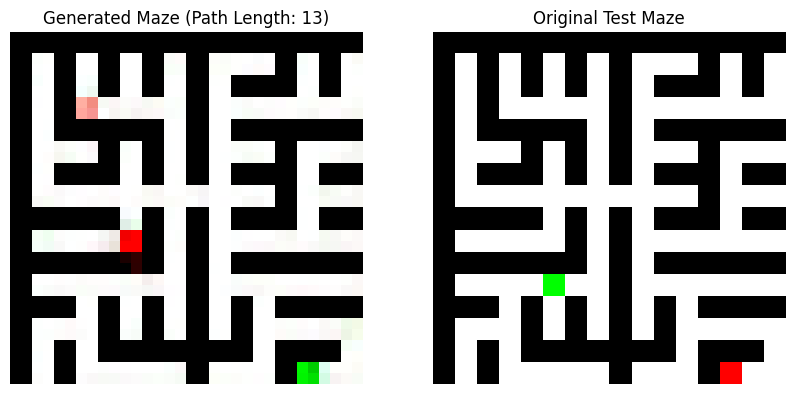

In [14]:
import torch
import random
import matplotlib.pyplot as plt

def generate_maze_from_test(sample_idx=None):
    vae.eval()

    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)

    test_img, test_path_length = test_dataset[sample_idx]  # Load test maze
    test_img = test_img.unsqueeze(0).to(device)  # Add batch dimension

    # Encode test maze image into latent space
    with torch.no_grad():
        latent_dist = vae.encode(test_img).latent_dist
        latent_sample = latent_dist.sample()  # Sample from the distribution

        # Decode latent back to an image
        generated_image = vae.decode(latent_sample).sample

    return generated_image, test_img, test_path_length

# Run test generation
generated, original, test_path_length = generate_maze_from_test()

# ---- Visualization ---- #
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze (Path Length: {test_path_length})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")

plt.show()
